In [1]:
import json
import re

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from textblob import TextBlob
from joblib import load

from sklearn import metrics
from sklearn.model_selection import train_test_split

import text_clf

In [2]:
with open('../dataset/goodreads_reviews_spoiler.json') as json_file:
    data = json.loads('[' + ',\n'.join(json_file.readlines()) + ']')

# Preprocess

In [3]:
def unpack(sents):
    ys = []
    xs = []
    for y, sent in sents:
        ys.append(y)
        xs.append(sent)
    return ys, xs

In [4]:
x = []
y = []
for sample in tqdm(data):
    ans, sent = unpack(sample['review_sentences'])
    x.extend(sent)
    y.extend(ans)

100%|██████████| 1378033/1378033 [00:03<00:00, 405316.66it/s]


In [5]:
del data

In [6]:
for id, i in tqdm(enumerate(x), total=len(x)):
    text = re.sub(r'http\S+', '', i.lower())
    # text = str(TextBlob(text).correct())
    x[id] = text

100%|██████████| 17672655/17672655 [00:29<00:00, 601761.71it/s]


In [7]:
prep_data = pd.DataFrame([x,y], index=['text', 'target']).T
prep_data = prep_data[~(prep_data['text'] == '')]
prep_data = prep_data[prep_data.apply(lambda x: len(x[0]) <= 500, axis=1)]

In [46]:
(17659023 - len(prep_data))/17659023

6.466948935963219e-05

In [47]:
prep_data['text'] = prep_data['text'].apply(lambda x: np.str_(x))

/tmp/ipykernel_4820/2054751173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prep_data['text'] = prep_data['text'].apply(lambda x: np.str_(x))


In [48]:
train, test = train_test_split(prep_data, test_size=0.2)

In [49]:
train.to_csv('dataset/train.csv', index=False)
test.to_csv('dataset/test.csv', index=False)

# TF-IDF baseline

In [2]:
model, target_names_mapping = text_clf.train(path_to_config='baseline_config.yaml')

text-clf-train - INFO - Config:

seed: 42
path_to_save_folder: models
experiment_name: model

# data
data:
  train_data_path: dataset/train.csv
  test_data_path: dataset/test.csv
  sep: ','
  text_column: text
  target_column: target

# preprocessing
# (included in resulting model pipeline, so preserved for inference)
preprocessing:
  lemmatization: null  # pymorphy2

# tf-idf
tf-idf:
  lowercase: true
  ngram_range: (1, 1)
  max_df: 0.5
  min_df: 1

# logreg
logreg:
  penalty: l2
  C: 1.0
  class_weight: balanced
  solver: saga
  n_jobs: -1

# grid-search
grid-search:
  do_grid_search: false
  grid_search_params_path: hyperparams.py
text-clf-train - INFO - Loading data...
text-clf-train - INFO - Train dataset size: 14126304
text-clf-train - INFO - Test dataset size: 3531577
text-clf-train - INFO - Fitting TF-IDF + LogReg model...
[Pipeline] ............ (step 1 of 2) Processing tf-idf, total= 3.6min
[Pipeline] ............ (step 2 of 2) Processing logreg, total=22.6min
text-clf-train 

/home/xx/anaconda3/envs/diploma/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


text-clf-train - INFO - Train classification report:

              precision    recall  f1-score   support

           0       0.98      0.77      0.86  13670521
           1       0.07      0.53      0.13    455783

    accuracy                           0.76  14126304
   macro avg       0.53      0.65      0.49  14126304
weighted avg       0.95      0.76      0.84  14126304

text-clf-train - INFO - Train confusion matrix:

          0        1
0  10527985  3142536
1    213990   241793

text-clf-train - INFO - Test classification report:

              precision    recall  f1-score   support

           0       0.98      0.77      0.86   3417771
           1       0.07      0.50      0.12    113806

    accuracy                           0.76   3531577
   macro avg       0.52      0.63      0.49   3531577
weighted avg       0.95      0.76      0.84   3531577

text-clf-train - INFO - Test confusion matrix:

         0       1
0  2627970  789801
1    56895   56911

text-clf-train - INF

# ROC AUC

In [4]:
model = load('models/model_2021-11-21_17-34-20/model.joblib')

In [5]:
print(model)

Pipeline(steps=[('tf-idf', TfidfVectorizer()),
                ('logreg',
                 LogisticRegression(class_weight='balanced', n_jobs=-1,
                                    random_state=42, solver='saga'))],
         verbose=True)


In [50]:
test_set = pd.read_csv('dataset/test.csv')
x = test_set['text'].astype('U')
y = test_set['target'].to_list()

In [35]:
x_pred = model.predict_proba(test_set['text'].astype('U'))
pred = x_pred[:, 0]

/home/xx/anaconda3/envs/diploma/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


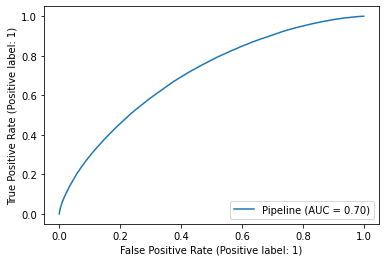

In [51]:
metrics.plot_roc_curve(model, x, y) 